<a href="https://colab.research.google.com/github/StuartLiv/CPSC-440-Project/blob/main/v0/shot0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# workflow notebook

Used reference:
-  [git in colab](https://www.geeksforgeeks.org/how-to-install-and-use-git-in-google-colab/)!

# 0. Open ipynb from github
To get this latest notebook from our repo into colab:
> "Open in colab" button == {Download from github} + {Upload to colab} - {Gets saved to drive}

# 1. Set up project in runtime
The following cell runs git config, clones the repo to get datasets as runtime files, and cds into project directory.

In [2]:
!git clone https://[token]@github.com/StuartLiv/CPSC-440-Project.git

fatal: destination path 'CPSC-440-Project' already exists and is not an empty directory.
fatal: not in a git directory
fatal: not in a git directory


In [3]:
!git config –global user.email “zivenanderson@msn.com”
!git config –global user.name “ZivenA”

fatal: not in a git directory
fatal: not in a git directory


In [4]:
%pwd

'/content'

`git clone` seems too good to be true for getting a few GB of data into runtime, but `/datasets/` is up once clone is run! See:

In [21]:
import os
path = '/content/CPSC-440-Project/datasets/smallset_onesize/color'
files = os.listdir(path)
print(files)

['4354.jpg', '5925.jpg', '556.jpg', '5334.jpg', '5224.jpg', '2590.jpg', '5463.jpg', '6002.jpg', '3467.jpg', '1631.jpg', '1720.jpg', '1802.jpg', '2382.jpg', '4300.jpg', '6787.jpg', '6411.jpg', '107.jpg', '4397.jpg', '7090.jpg', '2573.jpg', '4855.jpg', '854.jpg', '6845.jpg', '6746.jpg', '5483.jpg', '4683.jpg', '1705.jpg', '946.jpg', '3493.jpg', '3011.jpg', '5317.jpg', '6167.jpg', '5481.jpg', '382.jpg', '16.jpg', '528.jpg', '1123.jpg', '1092.jpg', '1066.jpg', '1609.jpg', '2585.jpg', '2958.jpg', '181.jpg', '2332.jpg', '3871.jpg', '2046.jpg', '4101.jpg', '6932.jpg', '4080.jpg', '1377.jpg', '4670.jpg', '6448.jpg', '5672.jpg', '5797.jpg', '5848.jpg', '1548.jpg', '3979.jpg', '568.jpg', '2067.jpg', '5350.jpg', '6249.jpg', '600.jpg', '2939.jpg', '161.jpg', '3200.jpg', '4859.jpg', '1551.jpg', '4840.jpg', '989.jpg', '4626.jpg', '5543.jpg', '1598.jpg', '6447.jpg', '32.jpg', '3770.jpg', '2491.jpg', '3821.jpg', '3169.jpg', '1208.jpg', '2978.jpg', '6268.jpg', '7029.jpg', '6153.jpg', '4614.jpg', '57.jp

# 2. Preprocess data

Datasets:
- `smallset_onesize` [DEPRECATED - DO NOT USE]
  - Downloaded as is, [here](https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization).
  - 7130 color/gray pairs
  - Res 150x150
  - 0.232GB
- `largeset_multisize` [USE THIS ONE]
  - Stored in Github repo, made from combination of other datasets. Dataset construction code in repo too
  - 18329 color/gray pairs. (actually 18328 - had to delete photo 2507 due to strange resolution issues)
  - Res 128x128 (grayscale images also available in 64x64, 32x32, 16x16)
  - 401 MB



In [22]:
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array # TODO don't use keras
import cv2 as cv


''' Returns an array containing all images in folder, sorted by filename. Useful for color/gray/downsize versions in different folders with same filename.
@param path - directory with images
@return
'''
def make_image_arr(path):

  def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

  files = os.listdir(path)
  files = sorted_alphanumeric(files)

  arr = []
  for i in tqdm(files):
    img = cv.imread(path + '/'+i,1)
    img = img.astype('float32') / 255.0
    arr.append(img_to_array(img))

  return arr


In [23]:
color_arr = make_image_arr('/content/CPSC-440-Project/datasets/largeset_multisize/color')

100%|██████████| 18329/18329 [00:07<00:00, 2457.86it/s]


In [24]:
gray_arr = make_image_arr('/content/CPSC-440-Project/datasets/largeset_multisize/gray')

100%|██████████| 18329/18329 [00:05<00:00, 3072.58it/s]


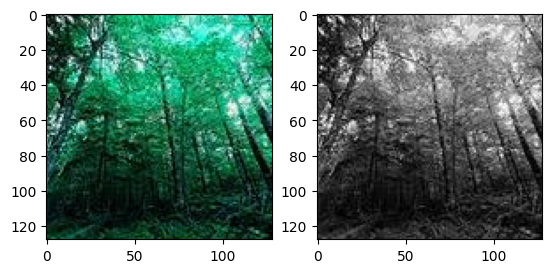

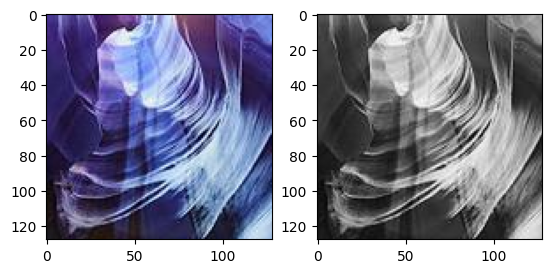

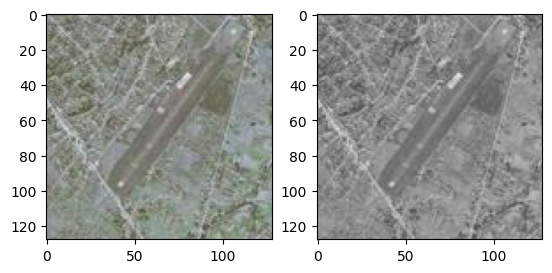

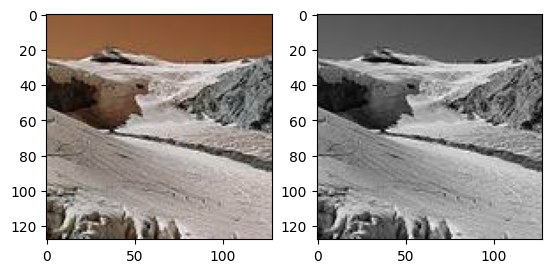

In [25]:
import matplotlib.pyplot as plt
import numpy as np

for i in np.random.randint(len(color_arr),size=4):
  plt.subplot(1,2,1)
  plt.imshow(color_arr[i])
  plt.subplot(1,2,2)
  plt.imshow(gray_arr[i])
  plt.show()

In [26]:
# Make a tensor list of reformatted images (based on Stuarts's axis swap)
import torch
gray_tensors = []

for image in gray_arr:
    # Convert each image to a PyTorch tensor
    t = torch.from_numpy(np.moveaxis(image, [2, 1], [0, 2]))
    gray_tensors.append(t)

color_tensors = []

for image in color_arr:
    # Convert each image to a PyTorch tensor
    t = torch.from_numpy(np.moveaxis(image, [2, 1], [0, 2]))
    color_tensors.append(t)

# 3. Saving new model weights to project directory

Toy model generated below:

In [27]:
# prompt: pytorch colourization autoencoder

import torch
import torch.nn as nn
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the autoencoder
autoencoder = Autoencoder()



Train toy model:

In [30]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(7500):
        inputs = gray_tensors[i].unsqueeze(0)  # Add batch dimension
        targets = color_tensors[i].unsqueeze(0)  # Add batch dimension

        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('[%d] loss: %.3f' % (epoch + 1, running_loss / 7500))

print('Finished Training')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 3, 114, 128])) that is different to the input size (torch.Size([1, 3, 112, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (112) must match the size of tensor b (114) at non-singleton dimension 2

input.shape (128, 128, 3)


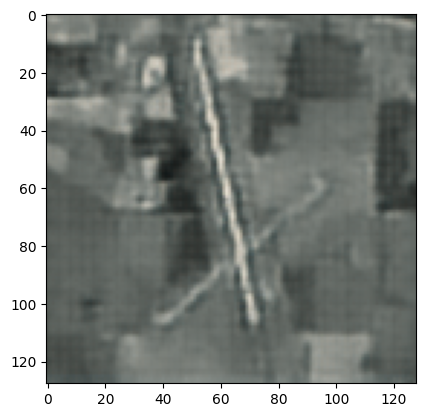

In [16]:
# Load the image
image = gray_arr[0]
print(f'input.shape {image.shape}')
# Colorize the image
# plt.imshow(image)
t = torch.from_numpy(np.moveaxis(image, [2, 1], [0,2]))
colorized_image = autoencoder(t)
colorized_image_format = np.moveaxis(colorized_image.detach().numpy(), [1,2], [0,1])
plt.imshow(colorized_image_format)

#Shows the axis swap is correct process:
#plt.imshow(np.moveaxis(np.moveaxis(image, [2,1], [0,2]), [1,2], [0,1]))

In [ ]:
torch.save(autoencoder.decoder,'/content/CPSC-440-Project/v0/decoder_weights')

# 4. Push changes

Look for any changes in the project directory, excluding this notebook, and push them.


In [31]:
!git add .

fatal: not a git repository (or any of the parent directories): .git


In [32]:
!git status

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!git commit -m "Message here"

In [ ]:
!git push

# 5. Save notebook

Commiting this notebook requires a special maneuver:

> File > Save a copy in github > enter original `path` + new commit msg

That's it!